# **NYC TLC Trip Record Dataset Overview**

## **Introduction**
he NYC TLC Trip Record Dataset is a publicly available dataset that contains detailed records of taxi trips in New York City. This dataset is released by the New York City Taxi and Limousine Commission (TLC) and is widely used for transportation analysis, traffic optimization, and fraud detection.

However, the dataset used only covers January 2023, meaning this analysis is limited to that specific time period. Additionally, three anomalous rows were found with years different from 2023. These anomalies have been separated to prevent distortion in the main analysis.

## **Data Collection Process**
The data is collected from taxi and for-hire vehicle (FHV) service providers through trip record submissions. These records are generated by taxi meters and dispatch systems, capturing important trip-related details.

## **Business Problem**
Reports indicate that overcharging by taxi drivers in New York City remains a concern. In November 2021, the city's Department of Investigation found that several taxi drivers had overcharged passengers by adding non-existent or inflated tolls. Four current and two former drivers pleaded guilty to felony charges related to this scheme.

Source: https://www.fox5ny.com/news/taxi-drivers-caught-overcharging-passengers

As of 2023, there have been no widely reported incidents of taxi drivers overcharging passengers in New York City. However, the city has implemented measures that affect taxi fares, such as congestion pricing. In 2023, taxis made about 12 daily trips, and passengers are responsible for paying the tolls, so it's advisable to check your receipts.

Source: https://www.fox5ny.com/news/nyc-congestion-pricing-how-uber-lyft-taxi-fares-impacted


The main objective of this analysis is to detect potential overcharging in taxi fares and examine whether overcharging trends persisted in 2023. Unfair pricing can damage customer trust and lead to regulatory action against service providers.


## **Analysis Objective**
To address the business problem of detecting potential overcharging in NYC taxi fares, we will analyze several key aspects of the dataset:

- **Identifying Unusual Fare Patterns**: Examining trip distances and total fares to detect cases where passengers may have been overcharged, either through inflated pricing or unnecessary detours.

- **Assessing External Factors Impacting Fare Variations**: Investigating how different conditions—such as peak hours, or major city events—affect fare pricing and whether any excessive charges are justified.

- **Examining Vendor Performance**: Analyzing fare discrepancies across different taxi service providers to determine if certain vendors have a higher rate of overcharging incidents.

This analysis will provide actionable insights to **detect unfair pricing**, **improve customer trust**, and **ensure compliance with NYC taxi regulations**.

## **Data Preparation**

### **Import Library**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

### **Import Dataset**

In [3]:
# Parse Date, so we dont need convert it to datetime.
df = pd.read_csv('NYC TLC Trip Record.csv', parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'])
df_zone = pd.read_csv('taxi_zone_lookup.csv')     

In [4]:
# Rename the columns first to avoid conflicts when merging
zone_pu = df_zone.rename(columns=lambda x: f"PU{x}" if x != "LocationID" else "PULocationID")
zone_do = df_zone.rename(columns=lambda x: f"DO{x}" if x != "LocationID" else "DOLocationID")

# Merge both pickup and drop-off zones in one go
df = df.merge(zone_pu, on="PULocationID", how="left").merge(zone_do, on="DOLocationID", how="left")


In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75,Manhattan,Morningside Heights,Boro Zone,Manhattan,Lincoln Square West,Yellow Zone
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00,Manhattan,Bloomingdale,Yellow Zone,Manhattan,Central Park,Yellow Zone
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00,Queens,Steinway,Boro Zone,Queens,Old Astoria,Boro Zone
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,Upper West Side North,Yellow Zone
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,East Harlem North,Boro Zone


### **Data Understanding**

#### **Collected Data Fields**:
Each trip record typically includes:

- **Vendor ID**: Unique identifier for the trip's service provider.
- **Pickup & Drop-off Timestamps**: Start and end times of the trip.
- **Store & Forward Flag**: Indicates if the trip data was temporarily stored before being sent to the server.
- **Rate Code ID**: The fare rate category applied.
- **Pickup & Drop-off Location IDs**: TLC Taxi Zone identifiers where the trip began and ended.
- **Pickup & Drop-off Boroughs**: The borough (Manhattan, Brooklyn, Queens, etc.) where the trip started and ended.
- **Pickup & Drop-off Zones**: The specific TLC-defined zone names for pickup and drop-off locations.
- **Pickup & Drop-off Service Zones**: The service zone classification (e.g., airports, green taxis, or high-volume FHV areas).
- **Passenger Count**: Number of passengers, manually entered by the driver.
- **Trip Distance**: Total distance traveled in miles, recorded by the taximeter.
- **Fare Amount**: Base fare calculated by time and distance.
- **Extra Charges**: Additional fees such as rush hour and overnight surcharges.
- **MTA Tax**: Fixed $0.50 tax applied based on metered rate.
- **Tip Amount**: Automatically recorded for credit card transactions; cash tips are not included.
- **Tolls Amount**: Total toll costs for the trip.
- **E-Hail Fee**: Additional fees charged for electronic hailing services.
- **Improvement Surcharge**: $0.30 surcharge on hailed trips, introduced in 2015.
- **Congestion Surcharge**: Additional charge applied in congestion pricing zones.
- **Total Amount**: The final charge to the passenger, excluding cash tips.
- **Payment Type**: Numeric code representing the method of payment.
- **Trip Type**: Classification indicating whether the trip was a street hail or a dispatch.



In [6]:
# Check Range of numerical & time data, for categorical data check the sample with 5 max, also check the null value
def summarize_dataframe(df):
    summary = {}
    total_rows = len(df)

    for col in df.columns:
        num_nulls = df[col].isnull().sum()
        percent_nulls = (num_nulls / total_rows) * 100

        if pd.api.types.is_numeric_dtype(df[col]):
            value_range = f"Range: {df[col].min()} to {df[col].max()}"
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            value_range = f"Range: {df[col].min()} to {df[col].max()}"
        elif df[col].nunique() > 5:
            value_range = f"Unique values: {df[col].unique()[:5]}, etc"
        else:
            value_range = f"Unique values: {df[col].unique().tolist()}"

        summary[col] = {
            "Null Count": num_nulls,
            "Null Percentage": f"{percent_nulls:.2f}%",
            "Details": value_range
        }

    for key, value in summary.items():
        print(f"{key}:")
        print(f"  - Null Count: {value['Null Count']}")
        print(f"  - Null Percentage: {value['Null Percentage']}")
        print(f"  - {value['Details']}")
        print("-" * 50)


summarize_dataframe(df)

VendorID:
  - Null Count: 0
  - Null Percentage: 0.00%
  - Range: 1 to 2
--------------------------------------------------
lpep_pickup_datetime:
  - Null Count: 0
  - Null Percentage: 0.00%
  - Range: 2009-01-01 20:21:27 to 2023-02-01 03:10:05
--------------------------------------------------
lpep_dropoff_datetime:
  - Null Count: 0
  - Null Percentage: 0.00%
  - Range: 2009-01-02 11:07:31 to 2023-02-01 17:27:05
--------------------------------------------------
store_and_fwd_flag:
  - Null Count: 4324
  - Null Percentage: 6.34%
  - Unique values: ['N', 'Y', nan]
--------------------------------------------------
RatecodeID:
  - Null Count: 4324
  - Null Percentage: 6.34%
  - Range: 1.0 to 99.0
--------------------------------------------------
PULocationID:
  - Null Count: 0
  - Null Percentage: 0.00%
  - Range: 1 to 265
--------------------------------------------------
DOLocationID:
  - Null Count: 0
  - Null Percentage: 0.00%
  - Range: 1 to 265
----------------------------------

### **Data Cleaning**

#### **Check Duplicate Data**

In [7]:
# Basic Check
df.duplicated().sum()

0

#### **We should check duplicates based on:**

- **Trip Metadata:**
    - 'lpep_pickup_datetime', 'lpep_dropoff_datetime' → Unique time of trip
    - 'PULocationID', 'DOLocationID' → Where the trip started and ended
- **Trip Details:**

    - 'passenger_count' → Same trip but different passenger count could indicate errors
    - 'trip_distance' → If all other fields match but distances differ, data might be incorrect
    - 'fare_amount', 'total_amount' → If these differ, it's worth investigating
- **Payment & Fare (Optional):**
    - 'payment_type', 'tip_amount' → Some trips might be duplicates but have different payment records

In [8]:
def check_relevant_duplicates(df):
    relevant_combinations = [
        ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID'],
        ['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'passenger_count'],
        ['lpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance'],
        ['PULocationID', 'DOLocationID', 'fare_amount', 'total_amount']
    ]
    
    results = {}
    for cols in relevant_combinations:
        dup_count = df.duplicated(subset=cols).sum()
        if dup_count > 0:
            results[tuple(cols)] = dup_count

    return results

dup_results = check_relevant_duplicates(df)
for cols, count in dup_results.items():
    print(f"Duplicate count for {set(cols)}: {count}")


Duplicate count for {'lpep_dropoff_datetime', 'lpep_pickup_datetime', 'PULocationID', 'DOLocationID'}: 174
Duplicate count for {'lpep_pickup_datetime', 'PULocationID', 'passenger_count', 'DOLocationID'}: 195
Duplicate count for {'lpep_pickup_datetime', 'PULocationID', 'trip_distance', 'DOLocationID'}: 175
Duplicate count for {'PULocationID', 'total_amount', 'fare_amount', 'DOLocationID'}: 22648


#### **Duplicate Analysis in Taxi Data**

##### 1️. **Duplicate Check**: `{PULocationID, lpep_pickup_datetime, lpep_dropoff_datetime, DOLocationID}`
- **Count:** 174 duplicates  
- **Meaning:** There are 174 trips where the pickup & dropoff locations and timestamps are **exactly the same**.  
- **Possible Causes:**  
  - The same trip was logged multiple times (duplicate data entry).  
  - A data processing issue caused duplicate records.  

---

##### 2️. **Duplicate Check**: `{PULocationID, lpep_pickup_datetime, passenger_count, DOLocationID}`
- **Count:** 195 duplicates  
- **Meaning:** 195 trips share the **same pickup location, dropoff location, timestamp, and passenger count**.  
- **Possible Causes:**  
  - The same passenger was counted multiple times.  
  - Data entry errors.  
  - Ride-sharing scenarios where multiple bookings appear separately but are actually the same trip.  

---

##### 3️. **Duplicate Check**: `{PULocationID, lpep_pickup_datetime, trip_distance, DOLocationID}`
- **Count:** 175 duplicates  
- **Meaning:** 175 trips have the **same pickup, dropoff, time, and trip distance**.  
- **Possible Causes:**  
  - The same trip was recorded twice.  
  - Fare or tip might be different, but the trip details are identical.  
  - Possible technical data duplication.  

---

##### 4. **Duplicate Check:** `{PULocationID, total_amount, fare_amount, DOLocationID}`
- **Count:** **22,648 duplicates** 
- **Meaning:** A huge number of trips share the **same pickup & dropoff locations, fare, and total amount**.  
- **Possible Causes:**  
  - **Standard fares** for common routes (e.g., fixed-price airport trips).  
  - Data recording issue where financial transactions were duplicated.  
  - Many identical trips with the same fare (e.g., multiple people taking taxis from the same location to the same destination at the same rate).  

**Legitimacy Check:**  
After verifying the timestamps, the trips **occurred at different times**, meaning this is **not a data duplication issue but a legitimate pattern** in the data.  


In [9]:
# Drop duplicates for specific cases while keeping the first occurrence

# 1️. Remove exact duplicates of pickup & dropoff locations and timestamps
df = df.drop_duplicates(subset=['PULocationID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'DOLocationID'], keep='first')

# 2️. Remove duplicates with the same pickup, dropoff, timestamp, and passenger count
df = df.drop_duplicates(subset=['PULocationID', 'lpep_pickup_datetime', 'passenger_count', 'DOLocationID'], keep='first')

# 3️. Remove duplicates with the same pickup, dropoff, time, and trip distance
df = df.drop_duplicates(subset=['PULocationID', 'lpep_pickup_datetime', 'trip_distance', 'DOLocationID'], keep='first')

#  Point 4 is legitimate, so no action needed


### **Data Missing**

In [10]:
df.isna().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4324
RatecodeID                4324
PULocationID                 0
DOLocationID                 0
passenger_count           4324
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                68016
improvement_surcharge        0
total_amount                 0
payment_type              4324
trip_type                 4334
congestion_surcharge      4324
PUBorough                   66
PUZone                     132
PUservice_zone             198
DOBorough                  242
DOZone                     419
DOservice_zone             661
dtype: int64

#### **Elhail_fee (100% missing)**
    All the data are missing, so we gonna drop the columns

In [11]:
df = df.drop(columns='ehail_fee',axis=1)

#### **trip_type (6.35% missing)**
  - `trip_type` typically has values 1 (standard trip) or 2 (shared trip).
  - Since we want to analyze overcharging, filling missing data based on other patterns can lead to incorrect interpretation.
  - It is better to drop rows with missing values if only a small portion of the data is missing.


In [12]:
df = df.dropna(subset= 'trip_type')

#### **RatecodeID, passenger_count, store_and_fwd_flag, payment_type, congestion_surcharge (6.34% missing, possibly one group of data is missing)**
  - **RatecodeID**: This column is important for detecting the rate applied, so it should not be filled arbitrarily..
  - **payment_type**: This is important for the overcharging analysis, so if there is no clear pattern, it is better to drop the rows with missing values.
  - **congestion_surcharge**: This is crucial because it can affect the total fare. If the pattern of missing data is similar to `RatecodeID`, it is better to drop the rows.

In [13]:
df = df.dropna(subset=['RatecodeID', 'payment_type', 'congestion_surcharge'])

#### **passenger_count (6.35% missing)**
- The mode (most frequent value) is 1 (84.99% of the data).
- The majority of trips have only 1 passenger, so it makes sense to fill missing values with 1.

In [14]:
df['passenger_count'].fillna(1, inplace=True)

#### **store_and_fwd_flag** 
- indicates whether the trip was stored before being sent to the server is not critical for overpricing analysis. It can be filled with 'N' (default).


In [15]:
df['store_and_fwd_flag'].fillna('N',inplace=True)

##### **PUBorough, PUZone, PUservice_zone, DOBorough, DOZone, and DOservice_zone**
- Pickup/Dropoff Locations Not Mapped in the Zone Dataset
- Invalid or Unmatched Location IDs
- So we will be filled as **Unknown**

In [16]:
zone_columns = ['PUBorough', 'PUZone', 'PUservice_zone', 'DOBorough', 'DOZone', 'DOservice_zone']
df[zone_columns] = df[zone_columns].fillna('Unknown')

### **Remove Anomaly Data**
- Negative or Zero Fare Amounts:
    - The minimum fare_amount is -70.00, which is invalid.
    - The minimum total_amount is -71.50, which also suggests an issue
- Zero or Negative Distance:
    - trip_distance has a minimum of 0.00 miles, which might indicate errors in records where fare is still charged.
- Invalid Passenger Counts:
    - he minimum value is 0 passengers, which is illogical.
    - The maximum value is 9 passengers, which is higher than normal (NYC taxis usually allow up to 6).
    - But 9 still possible if it was  children groups
- Negative Tax, Extra, or Congestion
    - mta_tax has a minimum of -0.5 (should always be non-negative).
    - extra has a minimum of -2.5 (should be non-negative).
    - congestion_surcharge has a minimum of -2.75, which should not happen.
- There only 3 Data that not in 2023, gonna remove it since it was anomaly

In [17]:
# Negative or zero `fare_amount`, Negative or zero `total_amount` , Negative or zero `trip_distance`, 
# Invalid `passenger_count` (0 or extremely high values, but allow up to 9 for possible children groups)
df = df[(df['fare_amount'] > 0) & (df['total_amount'] > 0)]
df = df[df['trip_distance'] > 0]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 9)]

# Convert negative `mta_tax`, `extra`, and `congestion_surcharge` to NaN or 0.
df['mta_tax'] = df['mta_tax'].apply(lambda x: x if x >= 0 else 0)
df['extra'] = df['extra'].apply(lambda x: x if x >= 0 else 0)
df['congestion_surcharge'] = df['congestion_surcharge'].apply(lambda x: x if x >= 0 else 0)


In [18]:
# Keeping only 2023 Data
df = df[df['lpep_pickup_datetime'].dt.year == 2023]

### **Remove Data Doesnt Needed**
- Remove RatecodeId = 5 : Ratecode 5 usually means fixed-price rides

In [19]:
# Exclude fixed-rate trips (RatecodeID)
df = df[df['RatecodeID'] != 5]  # Ratecode 5 usually means fixed-price rides

### **EDA**

#### **Identifying Unusual Fare Patterns**
    Examining trip distances and total fares to detect cases where passengers may have been overcharged, either through inflated pricing or unnecessary detours.

In [20]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,1.0,24.18,1.0,1.0,2.75,Manhattan,Morningside Heights,Boro Zone,Manhattan,Lincoln Square West,Yellow Zone
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,1.0,15.84,1.0,1.0,0.00,Manhattan,Bloomingdale,Yellow Zone,Manhattan,Central Park,Yellow Zone
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,1.0,10.20,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,Upper West Side North,Yellow Zone
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,1.0,8.00,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,East Harlem North,Boro Zone
5,2,2023-01-01 00:53:31,2023-01-01 01:11:04,N,1.0,41,262,1.0,2.78,17.7,1.0,0.5,0.00,0.0,1.0,22.95,2.0,1.0,2.75,Manhattan,Central Harlem,Boro Zone,Manhattan,Yorkville East,Yellow Zone


In [21]:
# Calculate fare_per_mile and total_per_mileCalculate fare_per_mile and total_per_mile
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
df['total_per_mile'] = df['total_amount'] / df['trip_distance']


In [22]:
# Detect outliers using IQR (Interquartile Range)
Q1 = df['fare_per_mile'].quantile(0.25)
Q3 = df['fare_per_mile'].quantile(0.75)
IQR = Q3 - Q1

threshold_high = Q3 + 1.5 * IQR  # Upper outlier threshold
threshold_low = Q1 - 1.5 * IQR   # Usually not needed for fares

df['isOvercharge'] = np.where(df['fare_per_mile'] > threshold_high, 'Overcharge', 'Normal')


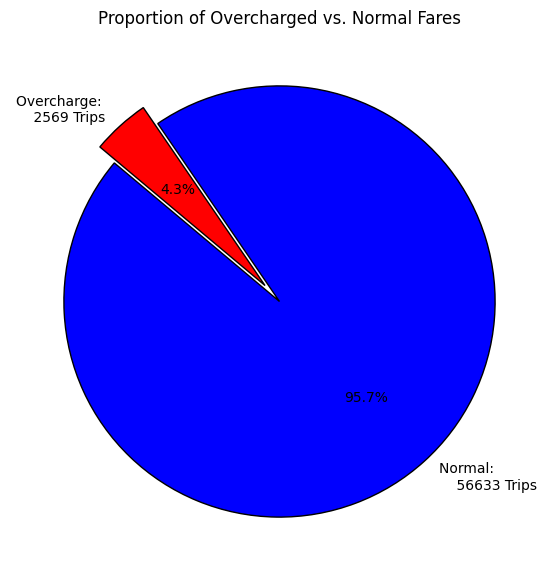

In [23]:
# Count occurrences of each category
overcharge_counts = df['isOvercharge'].value_counts()

# Define colors
colors = ['blue', 'red']  # Blue for normal, red for overcharge

# Explode the smallest slice
explode = [0.1 if count == overcharge_counts.min() else 0 for count in overcharge_counts]

# Create pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    overcharge_counts, 
    labels=[f'''{label}: 
    {count} Trips''' for label, count in overcharge_counts.items()],
    autopct='%1.1f%%', 
    colors=colors, 
    explode=explode,  # Separate the smallest slice
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proportion of Overcharged vs. Normal Fares")
plt.show()

#### **Assessing External Factors Impacting Fare Variations**:

The NYC Taxi and Limousine Commission (TLC) dataset includes specific columns that account for additional charges applied during certain periods or under specific conditions. These columns, such as extra, mta_tax, and improvement_surcharge, detail standard surcharges like rush hour fees, overnight charges, and mandated taxes. Given that these surcharges are explicitly recorded in the dataset, analyzing fare variations in relation to external events may not be necessary, as the data already accounts for these factors.



##### **Area Drop Off & Pick Up Zone Factor**

In [24]:
# Filter data where 'isOvercharge' is 'Overcharge'
overcharge_df = df[df['isOvercharge'] == 'Overcharge']

# Count and calculate the percentage of overcharge cases by Pickup Zone
pickup_overcharge = overcharge_df['PUZone'].value_counts().reset_index()
pickup_overcharge.columns = ['PUZone', 'Count']
pickup_overcharge['Percentage'] = (pickup_overcharge['Count'] / pickup_overcharge['Count'].sum()) * 100

# Count and calculate the percentage of overcharge cases by Dropoff Zone
dropoff_overcharge = overcharge_df['DOZone'].value_counts().reset_index()
dropoff_overcharge.columns = ['DOZone', 'Count']
dropoff_overcharge['Percentage'] = (dropoff_overcharge['Count'] / dropoff_overcharge['Count'].sum()) * 100

# Display the results
pickup_overcharge.head()


,PUZone,Count,Percentage
0,East Harlem North,332,12.923316
1,East Harlem South,316,12.300506
2,Central Harlem,229,8.913974
3,Forest Hills,191,7.434800
4,Elmhurst,157,6.111327


In [25]:
dropoff_overcharge.head()

,DOZone,Count,Percentage
0,East Harlem South,270,10.509926
1,East Harlem North,244,9.497859
2,Central Harlem,195,7.590502
3,Forest Hills,164,6.383807
4,Central Harlem North,137,5.332814


In [26]:
# Group by PUZone and isOvercharge, then calculate count and mean fare_per_mile correctly
zone_comparison = df.groupby(['PUZone', 'isOvercharge']).agg(
    Count=('fare_per_mile', 'count'),
    MeanFare=('fare_per_mile', 'mean')
).reset_index()

# Pivot the table to display data side by side
zone_comparison = zone_comparison.pivot(index='PUZone', columns='isOvercharge', values=['Count', 'MeanFare'])

# Rename columns for better readability
zone_comparison.columns = ['Normal_Count', 'Overcharge_Count', 'Normal_MeanFare', 'Overcharge_MeanFare']

# Fill NaN values with 0 (as some zones might have only one category)
zone_comparison = zone_comparison.fillna(0)

# Calculate total trips per zone
zone_comparison['Total_Count'] = zone_comparison['Overcharge_Count'] + zone_comparison['Normal_Count']

# Calculate the percentage of overcharge trips
zone_comparison['Overcharge_Percentage'] = round((zone_comparison['Overcharge_Count'] / zone_comparison['Total_Count']) * 100, 2)

# Reset index for a cleaner display
zone_comparison = zone_comparison.reset_index()

# Display the results
zone_comparison.sort_values('Overcharge_Count', ascending=False)


,PUZone,Normal_Count,Overcharge_Count,Normal_MeanFare,Overcharge_MeanFare,Total_Count,Overcharge_Percentage
53,East Harlem North,12331.0,332.0,6.694371,37.194977,12663.0,2.62
54,East Harlem South,8233.0,316.0,6.828079,45.487926,8549.0,3.70
30,Central Harlem,3373.0,229.0,7.161754,38.034773,3602.0,6.36
68,Forest Hills,3462.0,191.0,6.854818,90.669621,3653.0,5.23
60,Elmhurst,2569.0,157.0,6.668761,22.385998,2726.0,5.76
69,Fort Greene,1917.0,143.0,7.334870,16.461148,2060.0,6.94
109,Morningside Heights,3436.0,113.0,6.890729,46.778622,3549.0,3.18
31,Central Harlem North,1300.0,106.0,7.044604,35.863183,1406.0,7.54
88,Jackson Heights,1020.0,96.0,6.854361,28.986853,1116.0,8.60
1,Astoria,1492.0,96.0,6.995187,93.523807,1588.0,6.05


In [27]:
# Group by PUZone and isOvercharge, then calculate count and mean fare_per_mile correctly
zone_comparison = df.groupby(['DOZone', 'isOvercharge']).agg(
    Count=('fare_per_mile', 'count'),
    MeanFare=('fare_per_mile', 'mean')
).reset_index()

# Pivot the table to display data side by side
zone_comparison = zone_comparison.pivot(index='DOZone', columns='isOvercharge', values=['Count', 'MeanFare'])

# Rename columns for better readability
zone_comparison.columns = ['Normal_Count', 'Overcharge_Count', 'Normal_MeanFare', 'Overcharge_MeanFare']

# Fill NaN values with 0 (as some zones might have only one category)
zone_comparison = zone_comparison.fillna(0)

# Calculate total trips per zone
zone_comparison['Total_Count'] = zone_comparison['Overcharge_Count'] + zone_comparison['Normal_Count']

# Calculate the percentage of overcharge trips
zone_comparison['Overcharge_Percentage'] = round((zone_comparison['Overcharge_Count'] / zone_comparison['Total_Count']) * 100, 2)

# Reset index for a cleaner display
zone_comparison = zone_comparison.reset_index()

# Display the results
zone_comparison.sort_values('Overcharge_Count', ascending=False)


,DOZone,Normal_Count,Overcharge_Count,Normal_MeanFare,Overcharge_MeanFare,Total_Count,Overcharge_Percentage
65,East Harlem South,2997.0,270.0,7.457200,49.066329,3267.0,8.26
64,East Harlem North,2914.0,244.0,7.359704,42.972880,3158.0,7.73
34,Central Harlem,2238.0,195.0,7.816824,39.961444,2433.0,8.01
84,Forest Hills,1335.0,164.0,7.878743,27.905282,1499.0,10.94
35,Central Harlem North,2006.0,137.0,7.308005,26.120852,2143.0,6.39
72,Elmhurst,742.0,128.0,7.633738,24.167872,870.0,14.71
216,Upper East Side North,2490.0,108.0,7.079503,46.339257,2598.0,4.16
112,Jackson Heights,1099.0,100.0,7.447233,28.070456,1199.0,8.34
148,Morningside Heights,2029.0,95.0,7.334159,54.063538,2124.0,4.47
2,Astoria,899.0,79.0,7.309148,111.534400,978.0,8.08


##### **Most pickup and dropoff zones with overcharge cases still have the majority of rides classified as normal fare.**

- In nearly all zones, overcharge rides make up a small fraction of total rides.

- The only exception is Howard Beach, which has just one recorded ride, making it a possible anomaly.

##### **Only a small percentage of rides are classified as overcharge.**

- Although the number of overcharge rides is relatively small compared to the total rides, the fare per mile for overcharge rides is significantly higher (~$37.19 vs. $6.69 in East Harlem North, and ~$45.49 vs. $6.83 in East Harlem South).

- This indicates that when overcharge occurs, the price increase is substantial.

##### **Certain zones may be more prone to overcharge.**

- These areas might have specific patterns, such as high demand at certain times or surge pricing, leading to more frequent overcharge cases.

- It is also possible that certain drivers frequently operate in these zones and apply excessive fare markups.

#### **Vendor Factor**

In [28]:
# Group by VendorID and isOvercharge, then calculate count and mean fare_per_mile correctly
vendor_comparison = df.groupby(['VendorID', 'isOvercharge']).agg(
    Count=('fare_per_mile', 'count'),
    MeanFare=('fare_per_mile', 'mean')
).reset_index()

# Pivot the table to display data side by side
vendor_comparison = vendor_comparison.pivot(index='VendorID', columns='isOvercharge', values=['Count', 'MeanFare'])

# Rename columns for better readability
vendor_comparison.columns = ['Normal_Count', 'Overcharge_Count', 'Normal_MeanFare', 'Overcharge_MeanFare']

# Fill NaN values with 0 (as some vendors might have only one category)
vendor_comparison = vendor_comparison.fillna(0)

# Calculate total trips per vendor
vendor_comparison['Total_Count'] = vendor_comparison['Overcharge_Count'] + vendor_comparison['Normal_Count']

# Calculate the percentage of overcharge trips per vendor
vendor_comparison['Overcharge_Percentage'] = round((vendor_comparison['Overcharge_Count'] / vendor_comparison['Total_Count']) * 100, 2)

# Reset index for a cleaner display
vendor_comparison = vendor_comparison.reset_index()

# Display the results
vendor_comparison.sort_values('Overcharge_Count', ascending=False)


,VendorID,Normal_Count,Overcharge_Count,Normal_MeanFare,Overcharge_MeanFare,Total_Count,Overcharge_Percentage
1,2,49538.0,2292.0,6.773044,51.560844,51830.0,4.42
0,1,7095.0,277.0,6.287654,20.974753,7372.0,3.76


**Summary:**  
Although Vendor 1 has a slightly higher overcharge percentage (4.42% vs. 3.76%), the difference in mean fares is significantly more pronounced. Vendor 1’s overcharged trips average \$51.56 compared to \$6.77 normally, suggesting that when overcharging occurs, it is much more severe. Both vendors display cases of overcharging, indicating a need for improved monitoring and standardized pricing practices across the board.

In [29]:
# 1. Calculate the percentage for each category
pct_df = (
    df.groupby(['PUZone', 'VendorID'])['isOvercharge']
      .value_counts(normalize=True)
      .unstack() * 100
).reset_index()

# Format percentages to 2 decimal places
pct_df['Normal'] = round(pct_df['Normal'], 2)
pct_df['Overcharge'] = round(pct_df['Overcharge'].fillna(0), 2)

# Remove the column level name
pct_df.columns.name = None
pct_df = pct_df.reset_index(drop=True)

# 2. Calculate the count for each category
count_df = (
    df.groupby(['PUZone', 'VendorID'])['isOvercharge']
      .value_counts()
      .unstack()
).reset_index()

# Remove the column level name
count_df.columns.name = None
count_df = count_df.reset_index(drop=True)

# 3. Calculate the total count per combination (optional)
total_counts = df.groupby(['PUZone', 'VendorID']).size().reset_index(name='Total_count')

# 4. Merge the percentage data and counts
merged_df = pd.merge(pct_df, count_df, on=['PUZone', 'VendorID'], suffixes=('_percent', '_count'))
merged_df = pd.merge(merged_df, total_counts, on=['PUZone', 'VendorID'])

# Sort the merged dataframe by the Overcharge count in descending order
merged_df.sort_values('Overcharge_count', ascending=False)


,PUZone,VendorID,Normal_percent,Overcharge_percent,Normal_count,Overcharge_count,Total_count
89,East Harlem North,2,97.24,2.76,10052.0,285.0,10337
91,East Harlem South,2,96.28,3.72,7193.0,278.0,7471
47,Central Harlem,2,93.81,6.19,3046.0,201.0,3247
118,Forest Hills,2,94.83,5.17,3391.0,185.0,3576
102,Elmhurst,2,93.95,6.05,2375.0,153.0,2528
120,Fort Greene,2,92.58,7.42,1671.0,134.0,1805
184,Morningside Heights,2,96.92,3.08,3052.0,97.0,3149
2,Astoria,2,93.90,6.10,1402.0,91.0,1493
49,Central Harlem North,2,92.56,7.44,1132.0,91.0,1223
149,Jackson Heights,2,91.24,8.76,927.0,89.0,1016


**Summary:**  
Based on the analysis by pickup zone and vendor, there is not a significant difference between Vendor 1 and Vendor 2 regarding overcharging. Both vendors exhibit similar overcharge percentages and counts across most zones. While minor variations exist, the overall patterns suggest that overcharging is a consistent issue regardless of the vendor

## **Conclusion:**

Based on the analysis of the NYC TLC Trip Record dataset for January 2023, using the IQR method to identify fare anomalies, we found that there is an overcharging rate of approximately 4.3%, which translates to 2,569 trips. Although this percentage might seem low, the absolute number of potentially overcharged trips is significant.

### **Key findings include:**

- **Geographical Concentration:** Overcharging incidents are not evenly distributed across New York City. A notable concentration of these cases was observed in areas such as Harlem (both South and North) and other neighborhoods like Forest Hills, where the absolute number of trips with overcharging is higher.

- **Vendor Analysis:** Both Vendor 1 and Vendor 2 have recorded overcharging cases. While Vendor 2 tends to have a higher volume of trips, leading to more absolute cases of overcharging, Vendor 1 also shows instances of overcharging in certain zones.

- **Event Factors Not Considered:** Event factors, such as rush hour, were not explicitly analyzed in this study. This is because any additional charges related to peak times are already included in the "extra" field, meaning they do not directly affect the fare per mile or the fare/distance ratio used in our analysis.

### **Recommendations:**

- **Vendor Improvements:**: Both vendors should implement measures to reduce overcharging incidents. This could involve enhanced driver training and more rigorous internal monitoring of fare calculations.

- **Enhanced Monitoring:** Introduce a license plate tracking system and a driver feedback mechanism. Such tools can help in early identification and warnings for drivers who consistently engage in overcharging practices.

- **Educational Initiatives:** Develop and distribute comprehensive tour guidelines for high-risk areas (e.g., Harlem, Forest Hills) to educate both drivers and passengers. This initiative will help ensure that drivers adhere to fair pricing practices and that passengers are informed about standard fare expectations.

- **Regulatory Oversight:** Increase regulatory oversight to enforce transparency and compliance with fare calculation guidelines. Continuous monitoring can help maintain trust among consumers and prevent future incidents of overcharging.

Overall, while the percentage of overcharged trips is relatively low, the high absolute number and regional concentration suggest that targeted actions by both taxi vendors and city regulators are necessary to protect consumers and enhance fare fairness.

In [30]:
df.to_csv('TLC Clean For Dashboard.csv',index=False)